# Forecast Debugging: AEP_hourly Dataset

This notebook tests time series forecasting (ARIMA, SARIMA, RandomForest, Naive) using the AEP_hourly dataset. It is designed to help debug and identify issues in the forecasting pipeline.

**Outline:**
1. Import Required Libraries
2. Load and Inspect AEP_hourly Dataset
3. Preprocess Data for Forecasting
4. Visualize Time Series Data
5. Split Data into Train and Test Sets
6. Build and Fit Forecasting Models
7. Generate Forecasts
8. Evaluate Forecast Accuracy
9. Display Errors and Diagnostics


In [2]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [3]:
# 2. Load and Inspect AEP_hourly Dataset
DATASET_PATH = '../AEP_hourly.csv'  # Adjust path if needed

df = pd.read_csv(DATASET_PATH)
print('Shape:', df.shape)
display(df.head())
print('Missing values per column:')
print(df.isnull().sum())

Shape: (121273, 2)


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


Missing values per column:
Datetime    0
AEP_MW      0
dtype: int64


In [4]:
# 3. Preprocess Data for Forecasting
# Try to detect datetime and target columns
if 'Datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['Datetime'])
elif 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
else:
    # Try to auto-detect
    for col in df.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            df['datetime'] = pd.to_datetime(df[col])
            break
if 'AEP_MW' in df.columns:
    df['consumption'] = pd.to_numeric(df['AEP_MW'], errors='coerce')
else:
    # Try to auto-detect
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:
            df['consumption'] = pd.to_numeric(df[col], errors='coerce')
            break
# Drop rows with missing datetime or consumption
print('Before dropna:', df.shape)
df = df.dropna(subset=['datetime', 'consumption'])
print('After dropna:', df.shape)
df = df.set_index('datetime').sort_index()
display(df.head())


Before dropna: (121273, 4)
After dropna: (121273, 4)


,Datetime,AEP_MW,consumption
datetime,,,
2004-10-01 01:00:00,2004-10-01 01:00:00,12379.0,12379.0
2004-10-01 02:00:00,2004-10-01 02:00:00,11935.0,11935.0
2004-10-01 03:00:00,2004-10-01 03:00:00,11692.0,11692.0
2004-10-01 04:00:00,2004-10-01 04:00:00,11597.0,11597.0
2004-10-01 05:00:00,2004-10-01 05:00:00,11681.0,11681.0


In [ ]:
# 4. Visualize Time Series Data
plt.figure(figsize=(15,4))
plt.plot(df.index, df['consumption'], label='Consumption')
plt.title('AEP Hourly Consumption Over Time')
plt.xlabel('Datetime')
plt.ylabel('Consumption (MW)')
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# 5. Split Data into Train and Test Sets
# Use last 20% for test
split_idx = int(len(df) * 0.8)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]
print(f'Train shape: {train.shape}, Test shape: {test.shape}')


Train shape: (97018, 3), Test shape: (24255, 3)


In [6]:
# 6. Build and Fit Forecasting Models
models = {}
errors = {}

# ARIMA
try:
    arima_model = ARIMA(train['consumption'], order=(1,1,1)).fit()
    models['ARIMA'] = arima_model
    print('ARIMA fitted.')
except Exception as e:
    errors['ARIMA'] = str(e)
    print('ARIMA error:', e)

# SARIMA
try:
    sarima_model = SARIMAX(train['consumption'], order=(1,1,1), seasonal_order=(1,1,1,24)).fit(disp=False)
    models['SARIMA'] = sarima_model
    print('SARIMA fitted.')
except Exception as e:
    errors['SARIMA'] = str(e)
    print('SARIMA error:', e)

# RandomForest (with lag features)
try:
    train_rf = train.copy()
    train_rf['lag1'] = train_rf['consumption'].shift(1)
    train_rf = train_rf.dropna()
    X_train_rf = train_rf[['lag1']]
    y_train_rf = train_rf['consumption']
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_rf, y_train_rf)
    models['RandomForest'] = rf_model
    print('RandomForest fitted.')
except Exception as e:
    errors['RandomForest'] = str(e)
    print('RandomForest error:', e)

# Naive (no fitting needed)
models['Naive'] = train['consumption'].iloc[-1]
print('Naive model ready.')


ARIMA fitted.
SARIMA fitted.
SARIMA fitted.
RandomForest fitted.
Naive model ready.
RandomForest fitted.
Naive model ready.


In [7]:
# 7. Generate Forecasts
forecast_results = {}

# ARIMA
if 'ARIMA' in models:
    try:
        arima_pred = models['ARIMA'].forecast(len(test))
        forecast_results['ARIMA'] = arima_pred
        print('ARIMA forecast sample:', arima_pred[:5])
    except Exception as e:
        errors['ARIMA_forecast'] = str(e)
        print('ARIMA forecast error:', e)

# SARIMA
if 'SARIMA' in models:
    try:
        sarima_pred = models['SARIMA'].forecast(len(test))
        forecast_results['SARIMA'] = sarima_pred
        print('SARIMA forecast sample:', sarima_pred[:5])
    except Exception as e:
        errors['SARIMA_forecast'] = str(e)
        print('SARIMA forecast error:', e)

# RandomForest
if 'RandomForest' in models:
    try:
        test_rf = test.copy()
        test_rf['lag1'] = test_rf['consumption'].shift(1)
        test_rf = test_rf.dropna()
        X_test_rf = test_rf[['lag1']]
        rf_pred = models['RandomForest'].predict(X_test_rf)
        forecast_results['RandomForest'] = pd.Series(rf_pred, index=X_test_rf.index)
        print('RandomForest forecast sample:', rf_pred[:5])
    except Exception as e:
        errors['RandomForest_forecast'] = str(e)
        print('RandomForest forecast error:', e)

# Naive
try:
    naive_pred = [models['Naive']] * len(test)
    forecast_results['Naive'] = pd.Series(naive_pred, index=test.index)
    print('Naive forecast sample:', naive_pred[:5])
except Exception as e:
    errors['Naive_forecast'] = str(e)
    print('Naive forecast error:', e)


ARIMA forecast sample: 97018    14649.336411
97019    14524.360082
97020    14441.130923
97021    14385.703684
97022    14348.791393
Name: predicted_mean, dtype: float64
SARIMA forecast sample: 97018    14840.417175
97019    14836.242516
97020    14729.832404
97021    14684.234888
97022    14576.576433
Name: predicted_mean, dtype: float64
SARIMA forecast sample: 97018    14840.417175
97019    14836.242516
97020    14729.832404
97021    14684.234888
97022    14576.576433
Name: predicted_mean, dtype: float64
RandomForest forecast sample: [15199.13986335 14606.51398946 14687.9936692  14585.63751563
 14799.35929133]
Naive forecast sample: [14837.0, 14837.0, 14837.0, 14837.0, 14837.0]
RandomForest forecast sample: [15199.13986335 14606.51398946 14687.9936692  14585.63751563
 14799.35929133]
Naive forecast sample: [14837.0, 14837.0, 14837.0, 14837.0, 14837.0]


In [8]:
# 8. Evaluate Forecast Accuracy
for model, pred in forecast_results.items():
    # Align prediction and test
    if isinstance(pred, pd.Series):
        y_true = test.loc[pred.index, 'consumption']
        y_pred = pred
    else:
        y_true = test['consumption']
        y_pred = pred
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'{model} - MAE: {mae:.3f}, RMSE: {rmse:.3f}')


KeyError: "None of [Index([ 97018,  97019,  97020,  97021,  97022,  97023,  97024,  97025,  97026,\n        97027,\n       ...\n       121263, 121264, 121265, 121266, 121267, 121268, 121269, 121270, 121271,\n       121272],\n      dtype='object', name='datetime', length=24255)] are in the [index]"

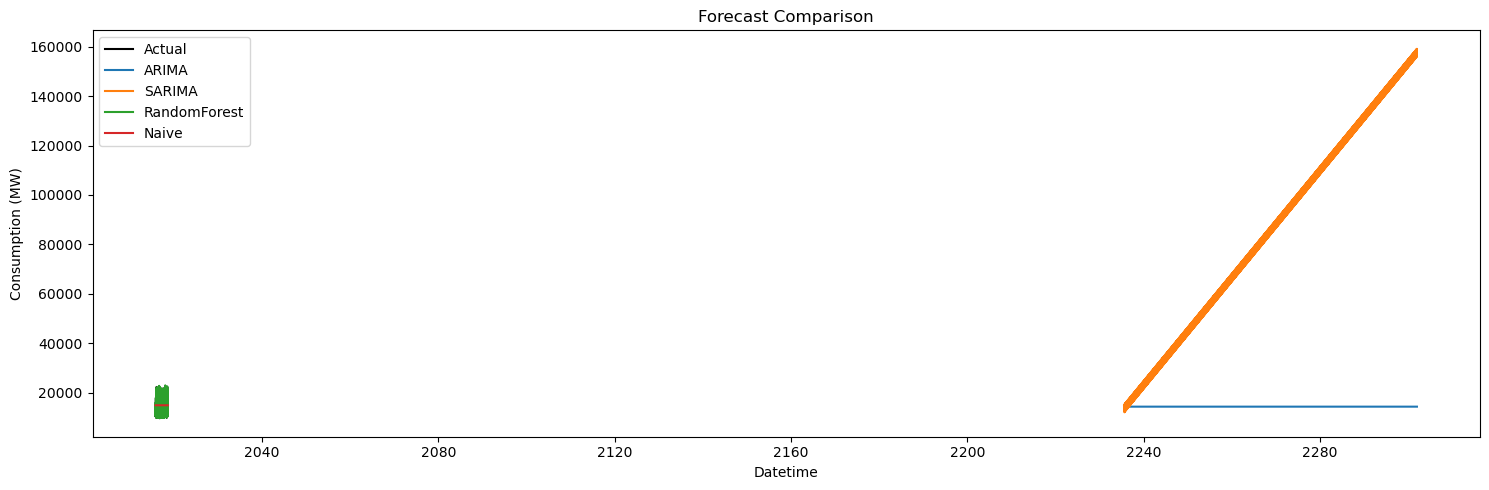

No errors encountered.


In [9]:
# 9. Display Errors and Diagnostics
plt.figure(figsize=(15,5))
plt.plot(test.index, test['consumption'], label='Actual', color='black')
for model, pred in forecast_results.items():
    if isinstance(pred, pd.Series):
        plt.plot(pred.index, pred, label=model)
    else:
        plt.plot(test.index, pred, label=model)
plt.title('Forecast Comparison')
plt.xlabel('Datetime')
plt.ylabel('Consumption (MW)')
plt.legend()
plt.tight_layout()
plt.show()

if errors:
    print('Errors encountered:')
    for k, v in errors.items():
        print(f'{k}: {v}')
else:
    print('No errors encountered.')
